<a href="https://colab.research.google.com/github/carsonashby/schoolProjects/blob/master/Carson_Ashby_portfolio_project_unit_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 3, Module 3*

---


# Permutation & Boosting

You will use your portfolio project dataset for all assignments this sprint.

## Assignment

Complete these tasks for your project, and document your work.

- [ ] If you haven't completed assignment #1, please do so first.
- [ ] Continue to clean and explore your data. Make exploratory visualizations.
- [ ] Fit a model. Does it beat your baseline? 
- [ ] Try xgboost.
- [ ] Get your model's permutation importances.

You should try to complete an initial model today, because the rest of the week, we're making model interpretation visualizations.

But, if you aren't ready to try xgboost and permutation importances with your dataset today, that's okay. You can practice with another dataset instead. You may choose any dataset you've worked with previously.

The data subdirectory includes the Titanic dataset for classification and the NYC apartments dataset for regression. You may want to choose one of these datasets, because example solutions will be available for each.


## Reading

Top recommendations in _**bold italic:**_

#### Permutation Importances
- _**[Kaggle / Dan Becker: Machine Learning Explainability](https://www.kaggle.com/dansbecker/permutation-importance)**_
- [Christoph Molnar: Interpretable Machine Learning](https://christophm.github.io/interpretable-ml-book/feature-importance.html)

#### (Default) Feature Importances
  - [Ando Saabas: Selecting good features, Part 3, Random Forests](https://blog.datadive.net/selecting-good-features-part-iii-random-forests/)
  - [Terence Parr, et al: Beware Default Random Forest Importances](https://explained.ai/rf-importance/index.html)

#### Gradient Boosting
  - [A Gentle Introduction to the Gradient Boosting Algorithm for Machine Learning](https://machinelearningmastery.com/gentle-introduction-gradient-boosting-algorithm-machine-learning/)
  - [An Introduction to Statistical Learning](http://www-bcf.usc.edu/~gareth/ISL/ISLR%20Seventh%20Printing.pdf), Chapter 8
  - _**[Gradient Boosting Explained](https://www.gormanalysis.com/blog/gradient-boosting-explained/)**_ — Ben Gorman
  - [Gradient Boosting Explained](http://arogozhnikov.github.io/2016/06/24/gradient_boosting_explained.html) — Alex Rogozhnikov
  - [How to explain gradient boosting](https://explained.ai/gradient-boosting/) — Terence Parr & Jeremy Howard

In [ ]:
import pandas as pd
import numpy as np

!wget "https://github.com/carsonashby/MyFiles/blob/master/34933-0001-Data.zip?raw=true"







--2021-02-03 20:14:10--  https://github.com/carsonashby/MyFiles/blob/master/34933-0001-Data.zip?raw=true
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/carsonashby/MyFiles/raw/master/34933-0001-Data.zip [following]
--2021-02-03 20:14:10--  https://github.com/carsonashby/MyFiles/raw/master/34933-0001-Data.zip
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/carsonashby/MyFiles/master/34933-0001-Data.zip [following]
--2021-02-03 20:14:10--  https://raw.githubusercontent.com/carsonashby/MyFiles/master/34933-0001-Data.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request

In [ ]:
!unzip '/content/34933-0001-Data.zip?raw=true'

Archive:  /content/34933-0001-Data.zip?raw=true
  inflating: 34933-0001-Data.sav     


In [ ]:
!pip install category_encoders==2.*
!pip install eli5
from category_encoders import OneHotEncoder
from numpy.random import permutation
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.impute import SimpleImputer
from sklearn.inspection import permutation_importance
from sklearn.pipeline import make_pipeline
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import numpy as np
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from category_encoders import OrdinalEncoder
!pip install mne
!pip install pyreadstat
import pyreadstat
import pandas as pd


     |████████████████████████████████| 81kB 3.4MB/s 
     |████████████████████████████████| 112kB 4.3MB/s 


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


     |████████████████████████████████| 6.9MB 5.3MB/s 
     |████████████████████████████████| 2.4MB 4.2MB/s 


In [ ]:

df = pd.read_csv("/content/C__Users_carso_Desktop_export_dataframe.csv")

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (31,861) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
keeplist  = ['CASEID', 'MJEVER', 'ALCEVER', 'COCEVER', 'HEREVER', 'LIFDEPRS', 'CIGEVER', 'CATAGE']

df = df[keeplist]

In [ ]:

df.dropna(axis=0, inplace=True)
df.set_index("CASEID", inplace = True)
df.head()

,MJEVER,ALCEVER,COCEVER,HEREVER,LIFDEPRS,CIGEVER,CATAGE
CASEID,,,,,,,
5.0,No,Yes,No,No,Response not entered,Yes,35 or Older
7.0,No,Yes,No,No,Response not entered,Yes,26-34 Years Old
9.0,No,Yes,No,No,Response entered,Yes,35 or Older
10.0,Yes,Yes,Yes,Yes,Response entered,Yes,18-25 Years Old
11.0,No,Yes,No,No,Response not entered,Yes,35 or Older


In [ ]:
import sklearn
from sklearn.model_selection import train_test_split

target = "MJEVER"
y = df[target]
X = df.drop(columns=target)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = .2, random_state = 42)

print(y_train.value_counts(normalize=True).max())

0.5291319857312723


In [ ]:
df.dtypes

CIGEVER     object
MJEVER      object
IRCIGRC     object
IICIGRC     object
II2CIGRC    object
             ...  
II2EMSTY    object
IIEMPST4    object
II2EMST4    object
PDEN00      object
COUTYP2     object
Length: 647, dtype: object

In [ ]:
model_skgb = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(),
    GradientBoostingClassifier(random_state=42)
)

model_skgb.fit(X_train, y_train);

In [ ]:
model_xgb = make_pipeline(
    OneHotEncoder(),
    SimpleImputer(),
    XGBClassifier(random_state=42,
                  n_jobs=10)
)

model_xgb.fit(X_train, y_train);

/usr/local/lib/python3.6/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [ ]:
model_tree = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(),
    RandomForestClassifier(n_estimators=50, n_jobs=-1, random_state=42)
)
model_tree.fit(X_train,y_train)

Pipeline(memory=None,
         steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['ALCEVER', 'COCEVER', 'HEREVER',
                                      'LIFDEPRS', 'CIGEVER', 'CATAGE'],
                                drop_invariant=False, handle_missing='value',
                                handle_unknown='value',
                                mapping=[{'col': 'ALCEVER',
                                          'data_type': dtype('O'),
                                          'mapping': Yes    1
No     2
NaN   -2
dtype: int64},
                                         {'col': 'COCEVER',
                                          'data_type': dtype('O'),
                                          'mapping': No     1
Yes    2
NaN   -2
dtype: int...
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=None, max_features='auto'

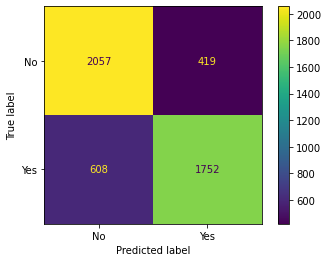

In [ ]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(model_tree, X_val, y_val, values_format='.0f')

In [ ]:
from category_encoders import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
model_lr = make_pipeline(
    OneHotEncoder(use_cat_names=True),
    SimpleImputer(strategy='mean'),
    LogisticRegression()
)

model_lr.fit(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


Pipeline(memory=None,
         steps=[('onehotencoder',
                 OneHotEncoder(cols=['ALCEVER', 'COCEVER', 'HEREVER',
                                     'LIFDEPRS', 'CIGEVER', 'CATAGE'],
                               drop_invariant=False, handle_missing='value',
                               handle_unknown='value', return_df=True,
                               use_cat_names=True, verbose=0)),
                ('simpleimputer',
                 SimpleImputer(add_indicator=False, copy=True, fill_value=None,
                               missing_values=nan, strategy='mean',
                               verbose=0)),
                ('logisticregression',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='auto', n_jobs=None,
                                    penal

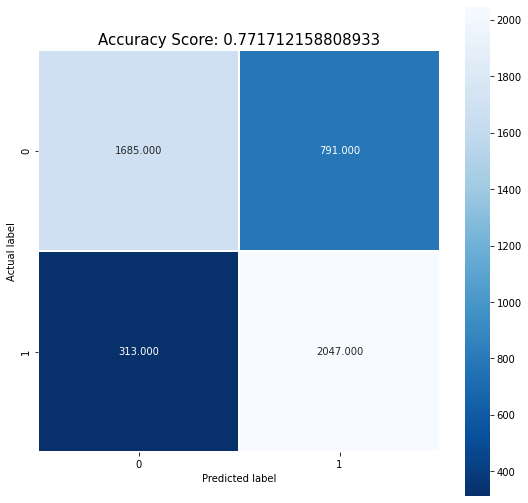

In [ ]:
import seaborn as sns
from sklearn import metrics

cm = metrics.confusion_matrix(y_val, model_lr.predict(X_val))
plt.figure(figsize=(9,9))
score = model_lr.score(X_val, y_val)
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 15);

In [ ]:

print('Validation Accuracy:', model_skgb.score(X_val, y_val))

print('Validation Accuracy:', model_xgb.score(X_val, y_val))

print('Validation Accuracy:', model_tree.score(X_val, y_val))

print('Validation Accuracy:', model_lr.score(X_val, y_val))

Validation Accuracy: 0.7878411910669976
Validation Accuracy: 0.7876344086021505
Validation Accuracy: 0.7876344086021505
Validation Accuracy: 0.771712158808933
